# ДЗ Классификация улова

В данном задании вам предстоит помочь The Nature Conservancy в борьбе с рыбаками-браконьерами. Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. За основу решения предлагается взять модель детектора:
https://github.com/a4tunado/lectures/blob/master/007/007-detection.ipynb. Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на Leaderboard. https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from imutils import paths
print(tf.__version__)

2.4.1


# Загружаем разметку

In [4]:
import os
import json
from glob import glob

TRAIN_PREFIX = '/content/drive/MyDrive/ML/datafish/train/train'

def load_annotations():
    boxes = dict()
    for path in glob('/content/drive/MyDrive/ML/datafish/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    yy = 0
    prob = 0  
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0), predict = None):
        yy = 0
        prob = 0
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
            
            if predict is not None:
                dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
                classes = ('ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT')
                classes_dict=dict_filter(rect, classes)
                print(rect)
                yy =  [k for k,v in classes_dict.items() if v==max(classes_dict.values())][0]
                prob =  [v for k,v in classes_dict.items() if v==max(classes_dict.values())][0]
                print('{} {}:{}'.format(annotation['filename'], yy, prob))
                print("\n ")
        return img, yy, prob
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        yy = 0
        prob = 0  
        
    img, yy , prob = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img, yy, prob = _draw(img, rectangles, 1., 1., (255, 0, 0), 1)

    return img , yy, prob

In [5]:
boxes = load_annotations()  # загружаем разметку детекций

Данные разбиты на 6 классов, в тестовом дата сете так же есть классы OTHER и NoF

In [6]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,alb,1719
1,bet,200
2,dol,117
3,lag,67
4,shark,176
5,yft,734


 Визуализируем разметку

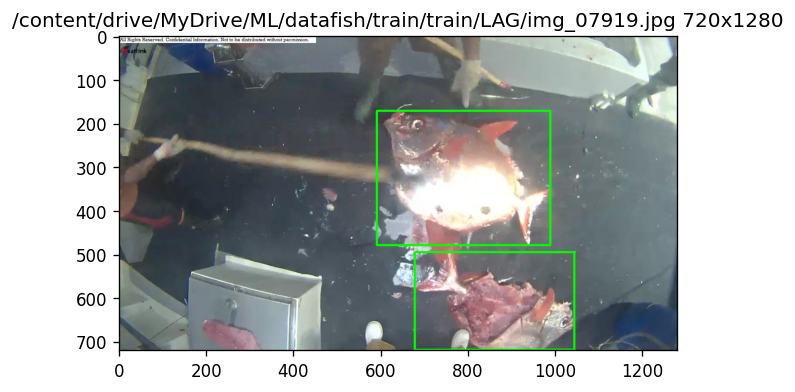

In [7]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img, yy, prob = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

In [8]:
sum(boxes.values(), [])[0]

{'annotations': [{'class': 'rect',
   'height': 151.06975503141317,
   'width': 383.68430384213445,
   'x': 739.0000000000025,
   'y': 268.8946201973347}],
 'class': 'image',
 'filename': '/content/drive/MyDrive/ML/datafish/train/train/ALB/img_07917.jpg'}

# Экстрактор признаков

In [9]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

58892288/58889256 [==============================] - 1s 0us/step
(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [11]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [12]:
sorted(list(map(str.upper, list(boxes.keys()))) + ['NoF','OTHER'])

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [13]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,         #площадь пересечений
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):

    y_label = annotation['filename'].split(os.path.sep)[-2]
    labels = sorted(list(map(str.upper, list(boxes.keys()))) + ['NoF','OTHER'])
   # y_label = labels.index(label)
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 13), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT

            encoded[row, col] = [1., dx, dy, dw, dh]  + [int(i == y_label) for i in labels]   # 13 каналов - признак объекта, x y w h и признак класса(8)
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh, classes0,classes1,classes2,classes3,classes4,classes5,classes6,classes7 = prediction[row, col]
            conf = _sigmoid(logit)
            anchor_x = ANCHOR_CENTERS[1, row, col]
            anchor_y = ANCHOR_CENTERS[0, row, col]
            if conf > conf_thr:
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'ALB':  _sigmoid(classes0),
                                   'BET':  _sigmoid(classes1),
                                   'DOL':  _sigmoid(classes2),
                                   'LAG':  _sigmoid(classes3),
                                   'NoF':  _sigmoid(classes4),
                                   'OTHER':  _sigmoid(classes5),
                                   'SHARK':  _sigmoid(classes6),
                                   'YFT':  _sigmoid(classes7)  })
            

             
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

Функция  encode в набор признаков каждого якоря добавляет признак класса по имени папки (1 если относится к указанному классу). Функция decode в полученном предсказании определяет вероятность принадлежности якоря к каждому из классов.

### Валидация энкодинга/декодинга якорей

{'x': 987.9999999712046, 'y': 382.5000001117587, 'width': 139.99999947845936, 'height': 80.99999874830246, 'conf': 0.7310585896677003, 'ALB': 0.5, 'BET': 0.5, 'DOL': 0.5, 'LAG': 0.7310585896677003, 'NoF': 0.5, 'OTHER': 0.5, 'SHARK': 0.5, 'YFT': 0.5}
/content/drive/MyDrive/ML/datafish/train/train/LAG/img_07817.jpg LAG:0.7310585896677003

 
{'x': 987.9999999712046, 'y': 382.50000062196153, 'width': 139.99999947845936, 'height': 80.99999874830246, 'conf': 0.7310585896677003, 'ALB': 0.5, 'BET': 0.5, 'DOL': 0.5, 'LAG': 0.7310585896677003, 'NoF': 0.5, 'OTHER': 0.5, 'SHARK': 0.5, 'YFT': 0.5}
/content/drive/MyDrive/ML/datafish/train/train/LAG/img_07817.jpg LAG:0.7310585896677003

 


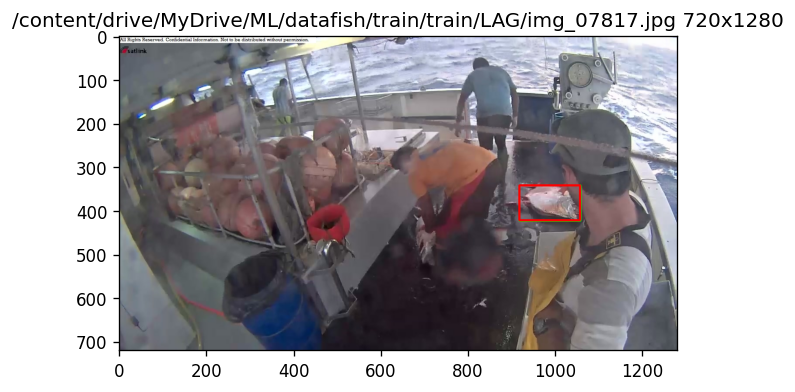

In [14]:
annotation = boxes['lag'][2]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
img, yy, prob = draw_boxes(annotation, decoded)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));


In [ ]:
encoded

In [86]:
decoded

[{'ALB': 0.5,
  'BET': 0.5,
  'DOL': 0.5,
  'LAG': 0.7310585896677003,
  'NoF': 0.5,
  'OTHER': 0.5,
  'SHARK': 0.5,
  'YFT': 0.5,
  'conf': 0.7310585896677003,
  'height': 80.99999874830246,
  'width': 139.99999947845936,
  'x': 987.9999999712046,
  'y': 382.5000001117587},
 {'ALB': 0.5,
  'BET': 0.5,
  'DOL': 0.5,
  'LAG': 0.7310585896677003,
  'NoF': 0.5,
  'OTHER': 0.5,
  'SHARK': 0.5,
  'YFT': 0.5,
  'conf': 0.7310585896677003,
  'height': 80.99999874830246,
  'width': 139.99999947845936,
  'x': 987.9999999712046,
  'y': 382.50000062196153}]

## Функция потерь

К итоговому занчению функции потерь добавлено значение функции множественной кросс энтропии.

In [15]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def classes_loss(y_true, y_pred):    # добавляем для множественной классификации
    ls = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    class_loss = ls(y_true[:, :, 4:], y_pred[:, :, 4:])
    return class_loss

def cross_entropy(y_true, y_pred):
        # y_pred /= tf.reduce_sum(y_pred, axis=-1, keep_dims=True)
        y_pred = K.maximum(K.minimum(y_pred, 1 - 1e-15), 1e-15)
        cross_entropy_loss = - K.sum(y_true * K.log(y_pred), axis=-1)
        return cross_entropy_loss

def custom_entropy(y_true, y_pred):
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

    loss = y_true * K.log(y_pred) 
    loss = -K.sum(loss, -1)

    return loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 13))
    y_pred = K.reshape(y_pred, (batch_size, -1, 13))

    class_loss = classes_loss(y_true, y_pred)

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss +  0.3*class_loss   # добавляем для множественной классификации

In [239]:
pred[0].shape

(23, 37, 13)

## Загрузка данных

In [16]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):

    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов    
                # добавлено в функциях encode и decode
                
                y.append(encode_anchors(boxes[j], img_shape)) 
                X.append(img)
                
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [17]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(13, # +8 классов
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 750, 1200, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 750, 1200, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 750, 1200, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 375, 600, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 375, 600, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 375, 600, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 187, 300, 128)     0     

## Обучение

In [18]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss])   # добавляем для множественной классификации


In [ ]:
batch_size = 10

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = 150 #sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector-2.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10
 10/150 [=>............................] - ETA: 9:51 - loss: 2.1069 - confidence_loss: 0.7991
Epoch 00001: loss improved from inf to 2.10694, saving model to fishdetector-2.hdf5
 20/150 [===>..........................] - ETA: 9:43 - loss: 1.7752 - confidence_loss: 0.7964
Epoch 00001: loss improved from 2.10694 to 1.77516, saving model to fishdetector-2.hdf5
 30/150 [=====>........................] - ETA: 8:57 - loss: 1.5930 - confidence_loss: 0.7546
Epoch 00001: loss improved from 1.77516 to 1.59303, saving model to fishdetector-2.hdf5
 40/150 [=======>......................] - ETA: 8:16 - loss: 1.4918 - confidence_loss: 0.7225
Epoch 00001: loss improved from 1.59303 to 1.49179, saving model to fishdetector-2.hdf5
 50/150 [=========>....................] - ETA: 7:36 - loss: 1.4113 - confidence_loss: 0.6981

 ...
 
Epoch 00010: loss did not improve from 0.81103
140/150 [===========================>..] - ETA: 11s - loss: 1.1553 - confidence_loss: 0.1378
Epoch 00010: loss did not improve from 0.81103
150/150 [==============================] - ETA: 0s - loss: 1.1902 - confidence_loss: 0.1370
Epoch 00010: loss did not improve from 0.81103
150/150 [==============================] - 166s 1s/step - loss: 1.1902 - confidence_loss: 0.1370
<tensorflow.python.keras.callbacks.History at 0x7f23c7f42d10>

## Результат работы детектора

In [ ]:
model.load_weights('/content/fishdetector-2.hdf5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp


{'x': 703.6415076134979, 'y': 429.0076552849749, 'width': 246.51989936828613, 'height': 266.00445806980133, 'conf': 0.2492545487738088, 'ALB': 0.4357281581638828, 'BET': 0.4051828148668517, 'DOL': 0.43842033571009825, 'LAG': 0.48393217041115794, 'NoF': 0.3910715347969699, 'OTHER': 0.4111919634169595, 'SHARK': 0.4863666602541424, 'YFT': 0.4399841495502002}
/content/drive/MyDrive/ML/datafish/train/train/LAG/img_05449.jpg SHARK:0.4863666602541424

 


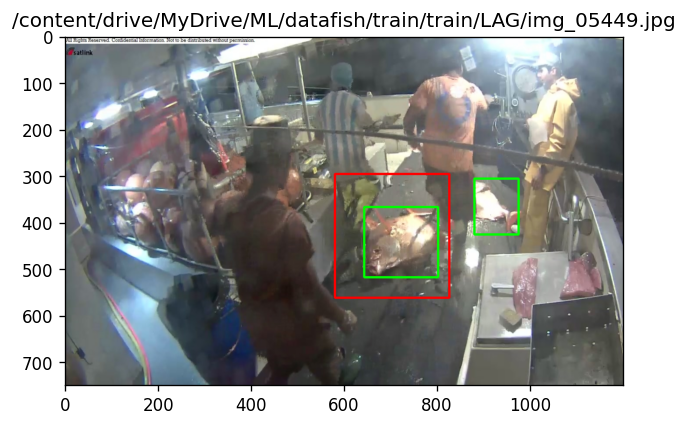

In [21]:
annotation = boxes['lag'][20]

# зеленый цвет заданная раметка
# красный цвет прогноз

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.0)
decoded = non_max_suppression(decoded,  max_output_size=1,  iou_threshold=0.3)
plt.figure(figsize=(6, 6), dpi=120)
plt.title('{}'.format(annotation['filename']))
img, yy, prob = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
#print('{} {}:{}'.format(annotation['filename'], yy, prob))

plt.imshow(img)


In [ ]:
pred[0]

In [ ]:
decoded

## Визуализируем предсказание на тесте

In [ ]:
#!pip install py7zr

In [51]:
#import py7zr 

#with py7zr.SevenZipFile('/content/drive/MyDrive/ML/datafish/test_stg2.7z',  mode='r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ML/datafish/test_stg2')

In [ ]:
#test_images = glob('/content/drive/MyDrive/ML/datafish/test_stg1/*.jpg')[:5]
test_images = glob('/content/drive/MyDrive/ML/datafish/test_stg2/test_stg2/*.jpg')[:5]

plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.3)
    decoded = non_max_suppression(decoded,
                                  max_output_size=1,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    img, yy, prob = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))

    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));




## Предсказание и формирование итогового результата

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [ ]:

import pandas
df3 = pandas.DataFrame()
ff3=[]

test_images = glob('/content/drive/MyDrive/ML/datafish/test_stg1/*.jpg')

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=1,
                                  iou_threshold=0.1)
    if len(decoded) == 0:
        df3 = df3.append([{'x': 0, 'y': 0,   'width': 0,   'height': 0, 'conf': 0,  'ALB':0.0,  'BET': 0.0, 'DOL': 0.0, 'LAG': 0.0,'NoF': 1.0,'OTHER': 0.0, 'SHARK': 0.0, 'YFT': 0.0}],ignore_index=True)
    else:
        df3 = df3.append(decoded[0],ignore_index=True)
    ff3.append(os.path.basename(filename).split('//', 1)[0] )

In [ ]:
test_images = glob('/content/drive/MyDrive/ML/datafish/test_stg2/test_stg2/*.jpg')

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=1,
                                  iou_threshold=0.1)
    if len(decoded) == 0:
        df3 = df3.append([{'x': 0, 'y': 0,   'width': 0,   'height': 0, 'conf': 0,  'ALB':0.0,  'BET': 0.0, 'DOL': 0.0, 'LAG': 0.0,'NoF': 1.0,'OTHER': 0.0, 'SHARK': 0.0, 'YFT': 0.0}],ignore_index=True)
    else:
        df3 = df3.append(decoded[0],ignore_index=True)

    ff3.append('test_stg2/'+os.path.basename(filename).split('//', 1)[0] )

In [ ]:
ff3 = pd.Series(ff3)
df3["image"] = ff3.values
df3 = df3[['image', 'ALB',	'BET',	'DOL',	'LAG',	'NoF',	'OTHER',	'SHARK',	'YFT']]
df3 = df3.set_index(['image'])

In [36]:
df3.to_csv('sample_submission_stg2.csv')

In [35]:
df3

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
image,,,,,,,,
img_00280.jpg,0.580633,0.429661,0.453431,0.433754,0.419135,0.422310,0.485688,0.464648
img_00311.jpg,0.577443,0.482241,0.448326,0.445746,0.433191,0.432066,0.468480,0.570473
img_00040.jpg,0.434890,0.451862,0.439586,0.409902,0.403694,0.403014,0.523590,0.582834
img_00005.jpg,0.446059,0.379748,0.369866,0.363951,0.346883,0.348813,0.402477,0.422352
img_00027.jpg,0.566927,0.423327,0.421513,0.397399,0.394519,0.388643,0.442843,0.461626
...,...,...,...,...,...,...,...,...
test_stg2/image_02013.jpg,0.395609,0.376914,0.367737,0.345665,0.343007,0.339836,0.384195,0.466786
test_stg2/image_02010.jpg,0.371709,0.438395,0.404350,0.393136,0.387951,0.380826,0.442566,0.540006
test_stg2/image_02078.jpg,0.566490,0.469840,0.489329,0.464440,0.446129,0.456534,0.540498,0.590308



1.98766   -  kaggle submmission score c применением  функции потерь кросс энтропии 